## Data search on hosts using API

In [1]:
import requests
from pathlib import Path
import json
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from datetime import timedelta

### Credentials

In [2]:
# PROJECT CREDENTIALS

# Path, load read json with credential secrets
proj_conf_file_path = Path.cwd()/'project-config-file.json'

# Opening JSON file and load into dict
open_proj_conf_file = open(proj_conf_file_path)
project_credentials = json.load(open_proj_conf_file)

In [3]:
# PROJECT CREDENTIALS

client_id = project_credentials['project_id']
client_secret = project_credentials['project_api_key']

### Functions

In [4]:
# Get access token
def get_ptoken(client_id, client_secret):
    response = requests.post("https://api.up42.com/oauth/token",
                             data={"grant_type": "client_credentials"},
                             auth=(client_id, client_secret)
                            )
    
    return response.json()["access_token"]

In [5]:
# Get all hosts

def get_list_hosts(PTOKEN):
    response = requests.get("https://api.up42.com/hosts",
                            data={"grant_type": "client_credentials"},
                            headers={"Authorization": "Bearer " + PTOKEN}
                           )
    return response.json()["data"]

# Search data through Hosts 
def search_hosts(PTOKEN, HOST_NAME):
    response = requests.post("https://api.up42.com/catalog/hosts/"+HOST_NAME+"/stac/search",
                            headers={"Authorization": "Bearer " + PTOKEN,
                                    "Content-Type" : "application/json"},
                             data=updated_payload
                           )
    return response.json()

### Available Hosts

In [6]:
# Build our host list calling "build_host_list()" function

PTOKEN = get_ptoken(client_id, client_secret)
#PTOKEN

hosts_name = get_list_hosts(PTOKEN)
current_host_list = [((hosts_name)[i]['name']) for i in range(len(hosts_name))]

In [7]:
current_host_list.remove('Sobloo')
current_host_list

['capellaspace', 'nearspacelabs', '21at', 'oneatlas', 'airbus']

### AOI

In [8]:
# Manage aoi file for use in payload or results plot

# AOI file path
aoi_file_path = Path.cwd()/'aoi/aoi_everest.geojson'
# Opening JSON file and load into variable aoi
aoi_file = open(aoi_file_path)
aoi = json.load(aoi_file)

# Use geopandas to read aoi file and extract aoi bounds
gpaoi = gp.read_file(aoi_file_path)
bounds = gpaoi.total_bounds

# Bbox coordinates for payload if wanted
bbox_coord = [bounds[0], bounds[1], bounds[2], bounds[3]]

# Intersects coordinate for payload if wanted
intersects_coord = aoi['features'][0]['geometry']

bbox_coord

[86.85928344726562, 27.953771424292043, 86.99523925781249, 28.032591760852497]

### Search parameters / Payload

In [9]:
# Search parameters from file - here we essentialy set a template payload that is built properly (we can update parameters in the next code block)

# File path
file_path = Path.cwd()/'search_params/sr_og.json'

# Opening JSON file and load into dict
sr_file = open(file_path)
payload = json.load(sr_file)
payload

{'datetime': '2019-03-22T00:00:00Z/2019-03-24T23:59:59Z',
 'intersects': {'type': 'Polygon',
  'coordinates': [[[13.58899063, 52.72706317],
    [13.8941314, 52.73057866],
    [13.89381997, 52.4393652],
    [13.58935102, 2.43718654],
    [1.58899063, 52.72706317]]]},
 'limit': 500,
 'collections': ['PHR'],
 'query': {'cloudCoverage': {'lte': 90},
  'resolution': {'lte': 0.3},
  'up42:usageType': {'in': ['DATA', 'ANALYTICS']},
  'deliveryTime': {'in': ['HOURS', 'MINUTES']},
  'producer': {'in': ['Airbus']},
  'processingLevel': {'in': ['ALBUM', 'SENSOR']}}}

In [10]:
# Search parameters - Update payload query options ("Airbus","TWENTY_ONE_AT", "ESA", "CAPELLA_SPACE", "NEAR_SPACE_LABS")
# The easiest might be building the json payload seperatly, this code block does however allow you to updated
# values from the template payload read in th eprevious code block. 
# You can modify the json by commenting on or off the del or payload lines to change you json payload file.

payload["datetime"] = "2010-07-01T00:00:00Z/2022-08-02T23:59:59Z"

#del payload["intersects"]
payload["intersects"] = intersects_coord

#del payload["bbox"]
#payload["bbox"] = bbox_coord

#del payload["limit"]
payload["limit"] = 500

del payload["collections"]
#payload["collections"] = ["capella-geo", "capella-sicd", "capella-slc"]

#del payload["query"]["cloudCoverage"]["lte"]
payload["query"]["cloudCoverage"]["lte"] = 50

del payload["query"]["resolution"]
#payload["query"]["resolution"]["lte"] = 5

del payload["query"]["producer"]
#payload["query"]["producer"]["in"] = []

del payload["query"]["up42:usageType"]
#payload["query"]["up42:usageType"]["in"] = []

del payload["query"]["processingLevel"]
#payload["query"]["processingLevel"]["in"] = []

del payload["query"]["deliveryTime"]
#payload["query"]["deliveryTime"]["in"] = []

updated_payload = json.dumps(payload)
updated_payload

'{"datetime": "2010-07-01T00:00:00Z/2022-08-02T23:59:59Z", "intersects": {"type": "Polygon", "coordinates": [[[86.85928344726562, 27.953771424292043], [86.99523925781249, 27.953771424292043], [86.99523925781249, 28.032591760852497], [86.85928344726562, 28.032591760852497], [86.85928344726562, 27.953771424292043]]]}, "limit": 500, "query": {"cloudCoverage": {"lte": 50}}}'

### Multiple host search

###### NOTE, I think it is more interesting to pass the results to geodataframe, should run test performance to see the difference but gp solutions allows to plot and access metadata easier

In [40]:
PTOKEN = get_ptoken(client_id, client_secret)

In [41]:
result = {}
for index, HOST_NAME in enumerate(current_host_list):
    print(f"Searching {HOST_NAME}")
    result[HOST_NAME] = search_hosts(PTOKEN, HOST_NAME)                   

Searching capellaspace
Searching nearspacelabs
Searching 21at
Searching oneatlas
Searching airbus


In [42]:
#result

In [43]:
hosts_to_remove = []
for i in result:
    try:
        result[i]['features'] == True
        print(f"{i} returned - - > {len(result[i]['features'])}")
    except:
        print(f"{i} - - > {result[i]['error']}")
        hosts_to_remove.append(i)
        continue

capellaspace returned - - > 0
nearspacelabs returned - - > 0
21at returned - - > 0
oneatlas returned - - > 268
airbus - - > {'code': 400, 'message': "Could not find host 'airbus'", 'details': None}


In [44]:
for i in hosts_to_remove:
    print(i)

airbus


In [16]:
# Remove errored search results
del result[hosts_to_remove[0]]

In [46]:
result

{'capellaspace': {'features': [],
  'links': [{'rel': 'self',
    'href': 'https://api.up42.com/catalog/hosts/capellaspace/stac/search'}],
  'type': 'FeatureCollection'},
 'nearspacelabs': {'features': [],
  'links': [{'rel': 'self',
    'href': 'https://api.up42.com/catalog/hosts/nearspacelabs/stac/search'}],
  'type': 'FeatureCollection'},
 '21at': {'features': [],
  'links': [{'rel': 'self',
    'href': 'https://api.up42.com/catalog/hosts/21at/stac/search'}],
  'type': 'FeatureCollection'},
 'oneatlas': {'features': [{'geometry': {'type': 'Polygon',
     'coordinates': [[[86.30038929, 29.91186617],
       [86.29622075, 29.29394416],
       [86.29633304, 29.28970503],
       [86.2923062, 28.66860877],
       [86.29174933, 28.66459289],
       [86.29732591, 28.03215124],
       [86.2958141, 28.02849346],
       [86.29814134, 27.72861502],
       [87.04465769, 27.67441187],
       [87.03644225, 27.97746864],
       [87.03750353, 27.98140604],
       [87.03511625, 28.61488515],
       [

In [45]:
# Results to geodataframe
gp_results = pd.concat([gp.GeoDataFrame.from_features(result['21at']), gp.GeoDataFrame.from_features(result['oneatlas'])])
#gp_results

,geometry,id,constellation,collection,providerName,up42:usageType,providerProperties,sceneId,producer,acquisitionDate,start_datetime,end_datetime,cloudCoverage,resolution,deliveryTime
0,"POLYGON ((86.30039 29.91187, 86.29622 29.29394...",16802d4d-0740-481d-a0cc-2a65d7915a89,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'SV...",16802d4d-0740-481d-a0cc-2a65d7915a89,airbus,2021-12-08T04:44:57.249Z,None,None,0.0,1.5,HOURS
1,"POLYGON ((86.30031 29.91190, 86.29629 29.29392...",03418bc2-9d3d-426c-88b2-cad43ac1d9b0,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'IJ...",03418bc2-9d3d-426c-88b2-cad43ac1d9b0,airbus,2021-12-08T04:44:57.249Z,None,None,0.0,1.5,HOURS
2,"POLYGON ((86.83105 28.29590, 86.84026 27.75149...",f8481648-f188-4571-a4c4-f89b1c081b1b,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'SV...",f8481648-f188-4571-a4c4-f89b1c081b1b,airbus,2021-12-05T04:19:51.249Z,None,None,0.0,1.5,HOURS
3,"POLYGON ((86.83108 28.29586, 86.84011 27.75167...",3aebad63-ddba-4a06-a9fd-b50133654c25,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'IJ...",3aebad63-ddba-4a06-a9fd-b50133654c25,airbus,2021-12-05T04:19:51.249Z,None,None,0.0,1.5,HOURS
4,"POLYGON ((86.83847 28.09660, 86.83930 27.97056...",5df93a7c-7896-4b68-ba75-ed6c0ed27736,pneo,pneo,oneatlas,[DATA],"{'qualified': False, 'lastUpdateDate': '2021-1...",5df93a7c-7896-4b68-ba75-ed6c0ed27736,airbus,2021-11-23T05:00:55.728Z,None,None,0.0,0.3,HOURS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,"POLYGON ((86.53288 28.38713, 86.53718 27.77220...",4bd95182-f2c7-4785-9011-d2ad2e2bd52c,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'FR...",4bd95182-f2c7-4785-9011-d2ad2e2bd52c,airbus,2012-11-07T10:43:52Z,None,None,8.4,1.5,HOURS
264,"POLYGON ((86.60250 28.37492, 86.60135 27.80406...",47fa7195-a313-4457-90a4-a3c89da9849f,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'FR...",47fa7195-a313-4457-90a4-a3c89da9849f,airbus,2012-11-05T10:59:02Z,None,None,2.1,1.5,HOURS
265,"POLYGON ((86.55505 28.35417, 86.56285 27.74775...",357eed0d-b989-478a-84ea-2c97dfcb5f6d,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'FR...",357eed0d-b989-478a-84ea-2c97dfcb5f6d,airbus,2012-10-31T21:54:11Z,None,None,0.0,1.5,HOURS
266,"POLYGON ((86.58142 28.35921, 86.58616 27.76928...",1982af2d-ab53-433d-a88c-c02ee5e6d95b,spot,spot,oneatlas,[DATA],"{'qualified': False, 'acquisitionStation': 'FR...",1982af2d-ab53-433d-a88c-c02ee5e6d95b,airbus,2012-10-24T10:51:38Z,None,None,29.5,1.5,HOURS


In [18]:
PTOKEN = get_ptoken(client_id, client_secret)

In [19]:
gp_results.keys()

Index(['geometry', 'id', 'constellation', 'collection', 'providerName',
       'up42:usageType', 'providerProperties', 'sceneId', 'producer',
       'acquisitionDate', 'start_datetime', 'end_datetime', 'cloudCoverage',
       'resolution', 'deliveryTime'],
      dtype='object')

In [20]:
count = (gp_results['collection'].value_counts())
print(count)

phr     133
spot    110
pneo     25
Name: collection, dtype: int64


In [37]:
maxdate = gp_results['acquisitionDate'].max()
mindate = gp_results['acquisitionDate'].min()
maxdate, mindate

('2021-12-08T04:44:57.249Z', '2012-10-17T10:55:28Z')

In [36]:
print(gp_results.acquisitionDate[0])

2021-12-08T04:44:57.249Z


### Work on search report export

### Plot results

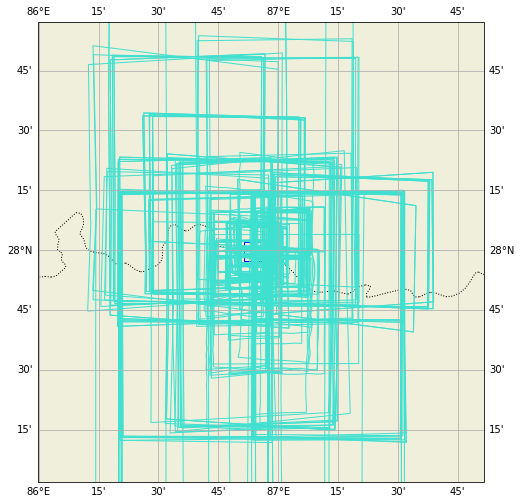

In [47]:
# Plot coverage
zoom_factor = 1
fig = plt.figure(figsize=(8, 12))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m', color='darkslategray', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=1)
ax.add_feature(cfeature.LAND, zorder=0)
ax.set_extent([bounds[0]+zoom_factor, bounds[2]-zoom_factor, bounds[1]+zoom_factor, bounds[3]-zoom_factor])
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax.add_geometries(gpaoi.geometry, crs=ccrs.PlateCarree(),
                  edgecolor='blue', facecolor='none', zorder = 2)
ax.add_geometries(gp_results.geometry, crs=ccrs.PlateCarree(),
                  edgecolor='turquoise', facecolor='none', zorder = 2)


plt.show()

If you have any questions or would like advice on other up42 things, feel free to reach out!!
Happy developing - Alex (alex.bishop@up42.com)